In [14]:
# !pip install "gymnasium==0.29.1" -q
# !pip install myosuite -q
# !pip install -q tqdm
# !pip install -q scipy
# !pip install -q matplotlib
# !pip install -q pandas
# !pip install -q skvideo
# !pip install osqp -q


In [15]:
from IPython.display import HTML
from myosuite.logger.grouped_datasets import Trace
import matplotlib.pyplot as plt
from base64 import b64encode
import scipy.sparse as spa
from copy import deepcopy
from tqdm import tqdm
import pandas as pd
import math
from myosuite.simhive.myo_sim.test_sims import TestSims as loader
import numpy as np
import skvideo.io
import mujoco
import osqp
import os

import logging

# Show everything
logging.getLogger().setLevel(logging.DEBUG)

# Utils

In [16]:
def solve_qp(P, q, lb, ub, x0, reg=1e-8, cond_thresh=1e10):
    """
    Solve a strictly convex box-QP: 0.5 x^T P x + q^T x s.t. lb <= x <= ub
    """
    # Regularize to avoid near-singularities - tikhonov regularization
    if P.ndim == 2:
        P = P + reg * np.eye(P.shape[0])
    P = spa.csc_matrix(P)

    A = spa.eye(q.shape[0], format="csc")  # box constraints
    m = osqp.OSQP()
    m.setup(
        P=P, q=q, A=A, l=lb, u=ub, verbose=False,
        max_iter=20000, eps_abs=1e-8, eps_rel=1e-8,
        polish=True, scaling=True  # enable scaling for stability
    )
    m.warm_start(x=x0)
    res = m.solve()
    return res.x

def map_error_to_joint(error, model):
    jnt_error_map = {} # jnt_name -> error
    for j in range(model.njnt):
        jnt_name = model.joint(j).name
        qpos_addr = model.jnt_qposadr[j]   # starting index in qpos
        jtype = model.jnt_type[j]
        
        if jtype == 0:   # free
          dim = 7
        elif jtype == 1: # ball
            dim = 4
        else:            # hinge/slide
            dim = 1
        
        jnt_error_map[jnt_name] = error[qpos_addr:qpos_addr+dim][0]
    return jnt_error_map

def plot_qpos(qpos_ref, qpos_test, model, not_present_joints=None):
    """
    Plot qforce (reference vs test) as time series with dots at every timestep.

    Args:
        qpos_ref (np.ndarray): Reference joint forces, shape (steps, joints)
        qpos_test (np.ndarray): Test joint forces, shape (steps, joints)
        model (mujoco.MjModel): MuJoCo model
        not_present_joints (list[int], optional): Indices of joints to plot
    """
    steps = qpos_ref.shape[0]
    time = np.arange(steps) * model.opt.timestep

    if not_present_joints:
        joint_names = [model.joint(i).name for i in not_present_joints]
        qpos_ref = qpos_ref[:, not_present_joints]
        qpos_test = qpos_test[:, not_present_joints]
    else:
        joint_names = [model.joint(i).name for i in range(model.njnt)]

    plt.figure(figsize=(12, 6))
    for i, name in enumerate(joint_names):
        # Reference (dashed + markers)
        plt.plot(
            time, qpos_ref[:, i],
            label=f"{name} (ref)",
            marker="o",
            markersize=3,
            linestyle="--"
        )

        # Test (solid + markers)
        plt.plot(
            time, qpos_test[:, i],
            label=f"{name} (test)",
            marker="o",
            markersize=3,
            linestyle="-"
        )

    plt.xlabel("Time (s)")
    title = "QPOS comparison (Reference vs Test)"
    plt.ylabel("QPOS - Rotation/Translation")
    plt.title(title)

    # Legend below the plot
    plt.legend(
        loc="upper center",
        bbox_to_anchor=(0.5, -0.15),
        ncol=4,   # adjust based on number of joints
        frameon=False
    )

    plt.tight_layout()
    filename = "qpos_comparison.png"
    plt.savefig(filename)
    print(f"Saved plot: {filename}")


# Preprocess Trajectory

In [17]:
def manual_trajectory(model, data, timesteps):
  """
  Modify the trajectory data with manual control
  """
  for j in range(model.njnt):
    jnt_name = model.joint(j).name
    if jnt_name == "r_shoulder_elev":
      data[jnt_name] = np.zeros(timesteps)
      data[jnt_name] = data[jnt_name].reshape(-1, 1)
      continue
    data[jnt_name] = np.linspace(0, np.deg2rad(90), timesteps)
    data[jnt_name] = data[jnt_name].reshape(-1, 1)
  
  return data

def build_qpos_in_model_order(model, trajectory_data, steps):
  """
  Rearrange trajectory_data (dict of joint_name -> (steps, dof) arrays)
  into a (steps, nq) array matching MuJoCo's qpos order.
  """
  nq = model.nq
  trajectory = np.zeros((steps, nq))
  not_present_jnt_indexes = []

  for j in range(model.njnt):
      jnt_name = model.joint(j).name
      qpos_addr = model.jnt_qposadr[j]   # starting index in qpos
      jtype = model.jnt_type[j]


      # dimension of this joint in qpos
      if jtype == 0:   # free
          dim = 7
      elif jtype == 1: # ball
          dim = 4
      else:            # hinge/slide
          dim = 1

      if jnt_name not in trajectory_data.keys():
        print(f"Joint: {jnt_name} not present. Initialise with zero value")
        not_present_jnt_indexes.append(j)
        # Initialise joint with zero value
        trajectory_data[jnt_name] = np.zeros(dim)
        continue

      vals = trajectory_data[jnt_name]   # shape (steps, dim)
      
      trajectory[:, qpos_addr:qpos_addr+dim] = vals

  return trajectory, not_present_jnt_indexes

# Compute Qforce

In [18]:
def reference_kinematics_from_qpos(model, qpos_ref, dt):
    """Compute qvel_ref (steps, nv) and qacc_ref (steps, nv) from qpos_ref."""
    T = qpos_ref.shape[0] # Number of steps
    nv = model.nv # number of degrees of freedom

    qvel_ref = np.zeros((T, nv))
    for i in range(T-1):
        mujoco.mj_differentiatePos(model, qvel_ref[i], dt, qpos_ref[i+1], qpos_ref[i]) # Returns velocity qvel_ref[i] required to move from qpos_ref[i+1] to qpos_ref[i] in dt
        # qvel_ref[i] = differentiate_pos_dm(model, qpos_ref[i+1], qpos_ref[i], dt)
    qvel_ref[-1] = qvel_ref[-2]  # pad last - Introduce slight error. Reduced as number of steps increases

    qacc_ref = np.zeros((T, nv))
    for i in range(1, T):
        qacc_ref[i] = (qvel_ref[i] - qvel_ref[i-1]) / dt
    qacc_ref[0] = qacc_ref[1]  # pad first - Introduce slight error. Reduced as number of steps increases
    return qvel_ref, qacc_ref

def get_qfrc_differentiation(model, data, ref_qpos, ref_qvel, ref_qacc):
    """
    Compute the generalized force needed to reach the target position in the next mujoco step.
    """
    data_copy = deepcopy(data)
    data_copy.qpos = ref_qpos
    data_copy.qvel = ref_qvel
    data_copy.qacc = ref_qacc

    old_flags = model.opt.disableflags
    model.opt.disableflags |= mujoco.mjtDisableBit.mjDSBL_CONSTRAINT # Constraints = contacts, joint limits, etc

    mujoco.mj_forward(model, data_copy)   # compute bias, gains, etc
    mujoco.mj_inverse(model, data_copy)   # compute inverse dynamics

    model.opt.disableflags = old_flags # Enable contraints
    return data_copy.qfrc_inverse

def get_qfrc_posdifference(model, data, target_qpos):
    """
    Compute the generalized force needed to reach the target position in the next mujoco step.
    """
    data_copy = deepcopy(data)
    data_copy.qacc = (((target_qpos - data.qpos) / model.opt.timestep) - data.qvel) / model.opt.timestep # Determine required acceleration
    model.opt.disableflags += mujoco.mjtDisableBit.mjDSBL_CONSTRAINT # Constraints = contacts, joint limits, etc
    mujoco.mj_inverse(model, data_copy)
    model.opt.disableflags -= mujoco.mjtDisableBit.mjDSBL_CONSTRAINT # Enable contraints
    return data_copy.qfrc_inverse

# Compute Control

In [19]:
def compute_tau(model, data, act_type="rise"):
  """
  Actuators = muscles, motors, general, etc
  tau_A/D = activation rise and activation decay
  activation is only applicable for muscles
  In case of non muscle activators, keep tau as 0
  """
  tau = np.zeros(model.nu, dtype=np.float64)
  for i in range(model.nu):
    actnum = model.actuator_actnum[i]   # number of activation states for actuator i (usually 0 or 1). Muscle 1, motor 0
    if actnum > 0:
        a = model.actuator_actadr[i] # starting index into data.act where that actuator’s activation state lives.
        act_i = float(data.act[a])
        if act_type=="rise":
          tau_base = model.actuator_dynprm[i, 0]
          tau[i] = tau_base * (0.5 + 1.5 * act_i)
        elif act_type=="decay":
          tau_base = model.actuator_dynprm[i, 1]
          tau[i] = tau_base / (0.5 + 1.5 * act_i)
    else:
        # print(i)
        tau[i] = 0.0   # No activation state → tau = 0
  return tau

def map_activation_states_to_actuators(model, data):
  act_full = np.zeros(model.nu, dtype=np.float64)

  for i in range(model.nu):
      actnum = model.actuator_actnum[i]   # 0 or 1
      if actnum > 0:
          adr = model.actuator_actadr[i]  # index into data.act
          act_full[i] = data.act[adr]
      else:
          act_full[i] = 0.0   # stateless actuator → no activation
  return act_full

def get_ctrl(model, data, qpos_ref, qvel_ref, qacc_ref, qfrc, qfrc_scaler, qvel_scaler):
  """
  Compute the control needed to reach the target position in the next mujoco step.
  qfrc: generalized force resulting from inverse dynamics.
  """
  act = data.act # shape = model.na = number of activation states
  ctrl0 = data.ctrl
  ts = model.opt.timestep
  tA = compute_tau(model, data, "rise")
  tD = compute_tau(model, data, "decay")
  tausmooth = model.actuator_dynprm[:,2]
  
  constant = 0.5

  t1 = (tA - tD) * 1.875 / tausmooth
  t2 = (tA + tD) * constant
  
  # ---- gain, bias, and moment computation
  data_copy = deepcopy(data)
  data_copy.qpos = qpos_ref
  data_copy.qvel = qvel_ref / qvel_scaler
  data_copy.qacc = qacc_ref

  mujoco.mj_step1(model, data_copy) # gain, bias, and moment depend on qpos and qvel

  gain = np.zeros(model.nu)
  bias = np.zeros(model.nu)
  for idx_actuator in range(model.nu):
      length = data_copy.actuator_length[idx_actuator]
      lengthrange = model.actuator_lengthrange[idx_actuator]
      velocity = data_copy.actuator_velocity[idx_actuator]
      acc0 = model.actuator_acc0[idx_actuator]
      prmb = model.actuator_biasprm[idx_actuator,:9]
      prmg = model.actuator_gainprm[idx_actuator,:9]
      bias[idx_actuator] = mujoco.mju_muscleBias(length, lengthrange, acc0, prmb)
      gain[idx_actuator] = min(-1, mujoco.mju_muscleGain(length, velocity, lengthrange, acc0, prmg)) # muscle gain is expected to be less than -1 - its stable/expected range

  # Compute actuator_moment. data_copy.actuator_moment is sparse.
  # https://github.com/google-deepmind/mujoco/blob/5d598a49a20b73deeb6e6b55b7adf2593ea3b3f6/python/LQR.ipynb#L494
  AM = np.zeros((model.nu, model.nv))
  mujoco.mju_sparse2dense(
      AM,
      data_copy.actuator_moment.reshape(-1),
      data_copy.moment_rownnz,
      data_copy.moment_rowadr,
      data_copy.moment_colind.reshape(-1),
  )
  
  # AM = data_copy.actuator_moment.reshape(model.nu, model.nv)
  AM = AM.T

  # ---- ctrl computation
  P = 2 * AM.T @ AM
  
  act = map_activation_states_to_actuators(model, data)
  k = AM @ (gain * act) + AM @ bias - (qfrc / qfrc_scaler)
  q = 2 * k @ AM
  lb = gain * (1 - act) * ts / (t2 + t1 * (1 - act))
  ub = - gain * act * ts / (t2 - t1 * act)
  x0 = (gain * (ctrl0 - act) * ts) / ((ctrl0 - act) * t1 + t2)
  x = solve_qp(P, q, lb, ub, x0)
  ctrl = act + x * t2 / (gain * ts - x * t1)
  return np.clip(ctrl,0,1)

In [20]:
model_name = "elbow/myoelbow_2dof6muscles.xml"
model1 = loader.get_sim(None, model_name)

tausmooth = 5
model1.actuator_dynprm[:,2] = tausmooth # Tausmooth is set to 5
data1 = mujoco.MjData(model1)
data1.qpos.shape, data1.qvel.shape, data1.qacc.shape, model1.nu, model1.nv, model1.nq, model1.na, model1.opt.timestep

((2,), (2,), (2,), 6, 2, 2, 6, 0.002)

In [21]:
horizon = 300
trajectory_data = {}

trajectory_data = manual_trajectory(model1, trajectory_data, horizon)
qpos_ref, not_present_jnt_indexes = build_qpos_in_model_order(model1, trajectory_data, horizon)

assert qpos_ref.shape[1] == data1.qpos.shape[0], "Shape mismatch for qpos"

dt = model1.opt.timestep
qvel_ref, qacc_ref = reference_kinematics_from_qpos(model1, qpos_ref, dt)

qpos_ref.shape, qvel_ref.shape, qacc_ref.shape


((300, 2), (300, 2), (300, 2))

100%|██████████| 300/300 [00:04<00:00, 66.87it/s]


Saved plot: qpos_comparison.png
Error(mean rads): 0.09337311684761339


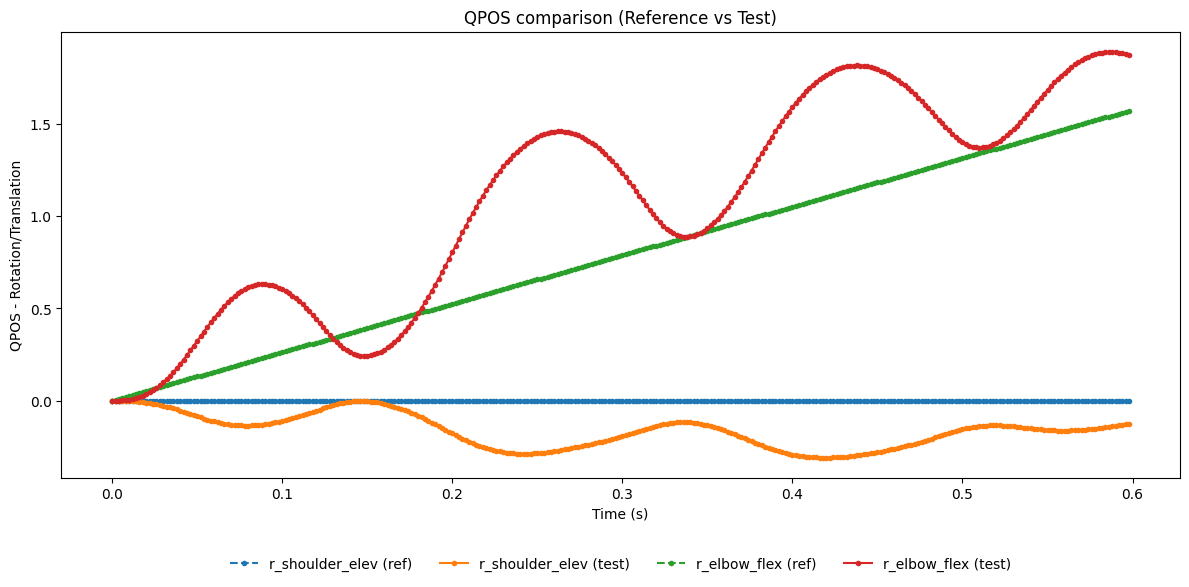

In [22]:
all_ctrl = np.zeros((qpos_ref.shape[0], 1+model1.nu)) # model.nu = number of actuators in the model
qpos_test = np.zeros((qpos_ref.shape[0], data1.qpos.shape[0]))
for idx in tqdm(range(qpos_ref.shape[0])):
    target_qpos = qpos_ref[idx, :]
    # qfrc = get_qfrc_differentiation(model1, data1, qpos_ref[idx], qvel_ref[idx], qacc_ref[idx])
    qfrc = get_qfrc_posdifference(model1, data1, target_qpos)
    ctrl = get_ctrl(model1, data1, qpos_ref[idx], qvel_ref[idx], qacc_ref[idx], qfrc, 10, 5)
    
    data1.ctrl = ctrl
    mujoco.mj_step(model1, data1)
    
    qpos_test[idx,:] = data1.qpos
    all_ctrl[idx,:] = np.hstack((data1.time, ctrl))
    
# Plot qforce
joint_names = [model1.joint(i).name for i in range(model1.njnt)]
plot_qpos(qpos_ref=qpos_ref, qpos_test=qpos_test, model=model1)

# Error metrics
error = ((qpos_test[:,:] - qpos_ref[:,:])**2).mean(axis=0)

print(f"Error(mean rads): {error.mean()}")

In [23]:
import mujoco
import numpy as np
import os, skvideo.io
from tqdm import tqdm

# ---- load models
model_ref = loader.get_sim(None, model_name)
model_ref.actuator_dynprm[:, 2] = tausmooth
data_ref = mujoco.MjData(model_ref)

model_test = loader.get_sim(None, model_name)
model_test.actuator_dynprm[:, 2] = tausmooth
data_test = mujoco.MjData(model_test)

# ---- camera (front view)
camera = mujoco.MjvCamera()
mujoco.mjv_defaultCamera(camera)
camera.azimuth = 90       # 0=front, 90=left, 180=back, 270=right
camera.elevation = -10   # tilt downward
camera.distance = 2.0
camera.lookat[:] = [0, 0, 1]

# ---- visualization options
scene_option = mujoco.MjvOption()
mujoco.mjv_defaultOption(scene_option)

# ---- renderers (offscreen)
renderer_ref = mujoco.Renderer(model_ref, height=480, width=640)
renderer_test = mujoco.Renderer(model_test, height=480, width=640)

frames_ref, frames_test = [], []
for idx in tqdm(range(qpos_ref.shape[0])):

    # --- Reference trajectory (direct playback)
    data_ref.qpos[:] = qpos_ref[idx]
    mujoco.mj_step1(model_ref, data_ref) # mj_step1: Only position dependent computations

    # --- Test trajectory (true simulation with controls)
    # data_test.qpos[:] = qpos_test[idx]
    ctrl_values = all_ctrl[idx, 1:]
    ctrl_values = np.nan_to_num(ctrl_values, nan=0.0, posinf=0.0, neginf=0.0)
    data_test.ctrl = ctrl_values  # apply controls    
    mujoco.mj_step(model_test, data_test)  # advance simulation
    
    # if not idx % round(0.3/(model_test.opt.timestep*25)):
    renderer_ref.update_scene(data_ref, camera=camera, scene_option=scene_option)
    frames_ref.append(renderer_ref.render())
    
    renderer_test.update_scene(data_test, camera=camera, scene_option=scene_option)
    frames_test.append(renderer_test.render())

# ---- save videos
outdir = "/Users/siddheshkanawade/Desktop/Siddhesh/Projects/myosuite-table-tennis/content/videos"
os.makedirs(outdir, exist_ok=True)


model_path = model_name
skvideo.io.vwrite(os.path.join(outdir, f"{model_path.split('/')[-1].split('.')[0]}_ref.mp4"),
                  np.asarray(frames_ref),
                  outputdict={"-pix_fmt": "yuv420p"})

skvideo.io.vwrite(os.path.join(outdir, f"{model_path.split('/')[-1].split('.')[0]}_test.mp4"),
                  np.asarray(frames_test),
                  outputdict={"-pix_fmt": "yuv420p"})

print("Videos saved successfully.")

100%|██████████| 300/300 [00:10<00:00, 28.03it/s]


Videos saved successfully.
